# Two step models notebook 3

## Billie Gould 1/6/2022

In [5]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

from featureio import FeatureIO 
from calzone import Calzone

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
#from pineapple.contrib.components.transformers.methyl.poisson_outlier import ChooseSettingsAndRegionsForPoissonV2
#from pineapple.contrib.specs.transformer_specs import ChooseSettingsAndRegionsForPoissonSpecV2

#from pineapple.contrib.results.results_loader import load_results
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader, ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 8, 19,0,0))

from collections import defaultdict, Counter
print("a")

STATISTICAL TESTS: The most common metric functions have been moved to Pineappleflow. Please import by 'from pineappleflow.core.statistics_utils'. Currently includes: SensAndSpecMetrics, get_sens_and_spec, specificity_threshold_interpolated, specificity_thresholds


a


In [ ]:
'''
for these models I fixed a bug where the specificity cutoff was being calculated on all samples
labeled 0 (including multicancers). now all multicancers are labeled as 1
'''

In [3]:
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS", "Colorectal Benign"]
CANCER_TYPES = ["Colorectal Cancer", "Colorectal Pre-Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]
COLORS = ["orange", "orange", "blue", "green", "grey", "pink", "lightblue", "purple", "lightgreen","yellow"]

def generate_exp_table(bucket, path=None, feature="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1", chains=1, spec=90, flyte=False, runid=None):
    if flyte is True:
        loader = FlyteExperimentLoader.from_run_id(runid)
    else:
        loader = ExperimentLoader(bucket,path)
    
    dfs = []
    for fold_name in loader.fold_names():
        fold_loader = loader.fold(fold_name)
        test_sids = fold_loader.post_transformer_fold_holder.test.sample_ids
        test_calls = fold_loader.model_fold_result.test.predictions
        chain_scores = fold_loader.post_transformer_fold_holder[feature].test.x
        #print(chain_scores.shape)
        metas = fold_loader.post_transformer_fold_holder[feature].test.sample_metadata
        stages = [m.raw_sample_metadata['lims_top_diagnosis']['stage'] for m in metas]
        df = pd.DataFrame.from_dict({"sample_id": test_sids, 
                                           "fold": [fold_name]*len(test_sids),
                                           "fold_call": test_calls,
                                           "stage": stages,
                                           })
        
        for i in range(chain_scores.shape[1]):
                df[f"chain_score_{i}"] = chain_scores[:,i]
        
        dfs.append(df)
                      
    df_calls = pd.concat(dfs, axis=0)
    
    # attach per fold calls to each sample
    table_loader = ExperimentTableLoader.from_experiment_loader(loader)
    df_samples = table_loader.sample_score_per_fold_table()
                   
    assert len(df_samples) == len(df_calls), f"Number total fold test samples {len(df_calls)} doesn't match number output samples {len(df_samples)}"
    
    df_samples_wcalls = pd.merge(df_samples, df_calls, on=["sample_id", "fold"], how="outer")
    
    assert len(df_samples_wcalls) == len(df_samples), f"Merged table {len(df_samples_wcalls)}. Orig: {len(df_samples)}"
    
    #	sample_id	fold	y_true	y_score	status	stage	subtype	inference chain0_score_mean chain1_score_mean
    return df_samples_wcalls


def plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90, score_col_name="y_score"):

    if method is "fold_score_avg":
        '''
        Final sample score is the mean score across folds. Final call is by 90 pct score spec threshold
        '''
        df_samples['score_mean'] = df_samples.groupby(['sample_id'])[score_col_name].transform(lambda x: np.mean(x))
        df_samples_avg = df_samples.drop_duplicates(subset=["sample_id"])
    
        healthies = [l in HEALTHY_TYPES for l in df_samples_avg["status"]]
        df_healthy = df_samples_avg[healthies]
        #final calls thresholded on average combined scores across each fold
        thresh = np.percentile(df_healthy["score_mean"].values, spec)
        df_samples_avg["call90"] = [1 if score>=thresh else 0 for score in df_samples_avg['score_mean']]        
        call_col = "call90"
    
    elif method is "by_fold":
        '''
        Final sample score is the assigned fold score from combine scores transformer. Final call is also
        from the combine scores transformer
        '''
        df_samples_avg = df_samples.copy()
        call_col = "fold_call"
    
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(df_samples_avg['status']):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l in (HEALTHY_TYPES + [i]) for l in df_samples_avg["status"]]
        df = df_samples_avg[subset]
        n_tp = np.sum([(lab==i) and (call==1) for lab,call in zip(df["status"],df[call_col])])
        if i not in ["Colorectal Cancer","Colorectal Pre-Cancer","Colorectal Benign"]:
            non_crcs += np.sum([s == i for s in df["status"]])
            sum_tps += n_tp
        call_rates.append(n_tp/np.sum([lab==i for lab in df["status"]]))
    
    call_rate_dict = dict(zip(types, call_rates))
    plot_rates = []
    for ct in CANCER_TYPES:
        if ct not in call_rate_dict.keys():
            plot_rates.append(np.nan)
        else:
            plot_rates.append(call_rate_dict[ct])
    
    fig, ax = plt.subplots()
#     prop_cycle = plt.rcParams['axes.prop_cycle']
#     colors = prop_cycle.by_key()['color']
    plt.bar(CANCER_TYPES, plot_rates, color=COLORS )
    plt.ylabel("Per Cancer Sensitivity")
    plt.ylim([0,1])
    plt.title(f"{os.path.basename(path)}\n method={method}")
    plt.xticks(CANCER_TYPES, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, plot_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    crc_sens = call_rates[list(types).index("Colorectal Cancer")]
    print(f"CRC Sens: {crc_sens}")
    print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")
    
    call_rate_dict["spec"] = []
    if method == "by_fold":
        for fold in np.unique(df_samples["fold"]):
            df_fold = df_samples[df_samples["fold"]==fold]
            n_tn = np.sum([y_true == 0 and y_pred == 0 for y_true, y_pred in zip(df_fold["y_true"],df_samples_avg["fold_call"])])
            call_rate_dict["spec"].append(float(n_tn)/len(df_fold[df_fold["y_true"]==0]))
        print(f"Avg fold spec: {np.mean(call_rate_dict['spec'])}")
    
    elif method == "fold_score_avg":
        n_tn = np.sum([(lab==0) and (call==0) for lab,call in zip(df_samples_avg["y_true"],df_samples_avg[call_col])])
        tot_neg = np.sum(np.array(df["y_true"])==0)
        call_rate_dict["spec"].append(n_tn/tot_neg)
        print(f"Final Spec: {n_tn/tot_neg}")
        
    return df_samples_avg, call_rate_dict

<>:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
/scratch/ipykernel_79774/2476327945.py:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is "fold_score_avg":
/scratch/ipykernel_79774/2476327945.py:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif method is "by_fold":


In [99]:
#output one sensitivity number per stage
def get_stage_sens(df_crc, method):
    stages_str = ['AA','1','2','3','4',None]
    sens = []
    sen_counts = []
    for stage in stages_str:
        if stage == 'AA':
            df_stage = df_crc[df_crc["status"]=="Colorectal Pre-Cancer"]
        elif stage == None:
            df_stage = df_crc[df_crc["status"]=="Colorectal Cancer"]
            df_stage = df_stage[df_stage["stage_x"].isnull()]
        else:
            df_stage = df_crc[df_crc["stage_x"]==stage]

        #print(f"stage:{stage}, {len(df_stage)}")
        if method == "fold_score_avg":
            tps = list(df_stage["call90"].values).count(1)
        elif method == "by_fold":
            tps = list(df_stage["fold_call"].values).count(1)

        tot = float(len(df_stage))
        if tot == 0:
            sen_final = np.nan
        else:
            sen_final = tps / tot
        sen_counts.append((tps, tot))
        sens.append(sen_final)
    tot_sen = np.sum([x[0] for x in sen_counts]) / float(np.sum([x[1] for x in sen_counts]))
    sens.append(tot_sen)

    return sens


def get_err_bars(df_samples):
    df_crc = df_samples[[t in ["Colorectal Cancer", "Colorectal Pre-Cancer"] for t in df_samples["status"]]]
    stage_fold_sens = defaultdict(list)
    for fold in np.unique(df_crc["fold"]):
        df_crc_fold = df_crc[df_crc["fold"] == fold]
        senAA, sen1, sen2, sen3, sen4, senNone, senTot = get_stage_sens(df_crc_fold, method="by_fold")
        stage_fold_sens["AA"].append(senAA)
        stage_fold_sens["1"].append(sen1)
        stage_fold_sens["2"].append(sen2)
        stage_fold_sens["3"].append(sen3)
        stage_fold_sens["4"].append(sen4)
        stage_fold_sens["None"].append(senNone)
        stage_fold_sens["Total"].append(senTot)
    
    def _remove_nan(ls):
        return [s for s in ls if np.isnan(s) == False]
    
    errors = []
    errors.append(np.std(_remove_nan(stage_fold_sens["AA"])))
    errors.append(np.std(_remove_nan(stage_fold_sens["1"])))
    errors.append(np.std(_remove_nan(stage_fold_sens["2"])))
    errors.append(np.std(_remove_nan(stage_fold_sens["3"])))
    errors.append(np.std(_remove_nan(stage_fold_sens["4"])))
    errors.append(np.std(_remove_nan(stage_fold_sens["None"])))
    errors.append(np.std(stage_fold_sens["Total"]))
    print(errors)
    return errors

def crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg", errors=None):
    '''
    input a sample by fold table or a sample averages table
    '''
    mask = [s in ["Colorectal Cancer", "Colorectal Pre-Cancer"] for s in df_sample_avg["status"]]
    df_crc_aa = df_sample_avg[mask] # this should include CRC and AA
    stages_str = ['AA','1','2','3','4',None]
    labels = []
    ns = []
    for stage in stages_str:
        if stage is None:
            df_crc = df_crc_aa[df_crc_aa["status"]=="Colorectal Cancer"]
            n = len(df_crc[df_crc["stage_x"].isnull()])
        elif stage == "AA":
            n = len(df_crc_aa[df_crc_aa["status"]=="Colorectal Pre-Cancer"])
        else:
            n = len(df_crc_aa[df_crc_aa["stage_x"]==stage])
        ns.append(n)
        labels.append(f"CRC-{stage}\n(n={n})")
    labels.append(f"Total\n(n={np.sum(ns)}")
    
    senAA, sen1, sen2, sen3, sen4, senNone, senTot = get_stage_sens(df_crc_aa, method="fold_score_avg")
    stage_sens = [senAA, sen1, sen2, sen3, sen4, senNone, senTot]    
        
    fig, ax = plt.subplots(figsize=(8,5))
    x = np.array(range(len(labels)))
    errors = [0.005 if e==0 else e for e in errors]
    ax.bar(x[:-1], stage_sens[:-1], color="blue", yerr=errors[:-1], label="stage sens.")
    ax.bar(x[-1], senTot, color = "lightblue", yerr=errors[-1], label="total sens.")
    pos = list(range(len(labels)))
    plt.xticks(pos, labels)
    ax.set_ylabel("Sensitivity @90 spec.")
    #plt.xticks((x + width), labels)
    plt.ylim((0,1.0))
    plt.title(f"{os.path.basename(path)}\n method:{method}") 
   # add bar labels
    #sens = [ s for sublist in sens for s in sublist]
    for rect, sen in zip(ax.patches, stage_sens):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(sen*100):.0f}%", ha="center", va="bottom")
    plt.legend()
    return stage_sens

In [ ]:
def plot_scores(df, method="fold_score_avg"):
    
    def _log(scores):
        return np.log(scores + 1)
    
    # plot chain0 vs. combined scores
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,7))
    
    df_crc = df[[s in ["Colorectal Cancer", "Colorectal Pre-Cancer"] for s in df["status"]]]
    
    if method == "fold_score_avg":
        chain0_col = "chain0_score_mean"
        combined_col = "score_mean"
    elif method == "by_fold":
        chain0_col = "chain0_score"
        combined_col = "y_score"
    
    ax[0].scatter(_log(df_crc[chain0_col]), _log(df_crc[combined_col]), color="red", label="CRC")
    df_healthy = df[[t in HEALTHY_TYPES for t in df["status"]]]
    ax[1].scatter(_log(df_healthy[chain0_col]), _log(df_healthy[combined_col]), color="blue", label="Healthy")
    df_mc = df[[t not in (HEALTHY_TYPES + ["Colorectal Cancer", "Colorectal Pre-Cancer"]) for t in df["status"]]]
    ax[2].scatter(_log(df_mc[chain0_col]), _log(df_mc[combined_col]), color="orange", label="Multicancer")
    model1_thresh = _log(np.percentile(df_healthy[chain0_col].values, 90))
    combined_thresh = _log(np.percentile(df_healthy[combined_col].values, 90))
    
    for i in range(3):
        ax[i].set_title(os.path.basename(path))
        ax[i].set_xlabel("log(model1_score + 1)")
        ax[i].vlines(x=model1_thresh, ymin=min(_log(df_sample_avg[combined_col]))-0.5,  
               ymax=max(_log(df_sample_avg[combined_col])), linestyle="--", color="black")
        ax[i].set_ylabel("log(combined_score + 1)")
        ax[i].hlines(y=combined_thresh, xmin=min(_log(df_sample_avg[chain0_col]))-0.5,  
               xmax=max(_log(df_sample_avg[chain0_col])), linestyle="--", color="black")
        ax[i].legend()

In [ ]:
def get_confusion_matrix(bucket, path):
    '''
    get the confusion matrix from models that run the combine_rule: filter_by_max_TOO. TOO calls
    are stored in the model recipe
    '''
    loader = ExperimentLoader(bucket,path)
    dfs = []
    reg_chosen_dict = defaultdict(list)
    for fold_name in loader.fold_names():
        fold_loader = loader.fold(fold_name)
        test_sids = fold_loader.post_transformer_fold_holder.test.sample_ids
        chain_scores = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test
        chain_scores_x = chain_scores.x
        chain_scores_cols = chain_scores.column_metadata
        #print(chain_scores[0:5,0:5])
        test_cancer_type = [m.cancer_type for m in fold_loader.post_transformer_fold_holder.test.sample_metadata]
        #combine_chains = fold_loader._pipeline_result.pipeline.transformer_chains['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'][0]
        #mult_class_model = combine_chains.transformer_chains[1][2]
        model_recipe = fold_loader.fitted_model_recipe
        TOO_calls = model_recipe.TOO_calls

        _df = pd.DataFrame.from_dict({"sample_id":test_sids, 
                                               "fold":[fold_name]*len(test_sids),
                                               "cancer_type": test_cancer_type,
                                               #"score": chain_scores_x,
                                              "TOO_call": TOO_calls})
        
        for i, col in enumerate([c["transformed_by_chain"] for c in chain_scores.column_metadata]):
            _df[col] = chain_scores_x[:,i]
            combine_chains = fold_loader._pipeline_result.pipeline.transformer_chains['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'][0]
            type_model = combine_chains.transformer_chains[i][0]
            n_reg_chosen = np.sum(type_model.features_to_keep)
            reg_chosen_dict[col].append(n_reg_chosen)
        
        dfs.append(_df)
            
    df2 = pd.concat(dfs, axis=0)
    print(Counter(df2["TOO_call"]))
    
    y = df2["cancer_type"]
    y = ["Healthy" if y_i in HEALTHY_TYPES else y_i for y_i in y]
    y_pred_dict = {"outlier_for_CRC": "Colorectal Cancer",
                   "outlier_for_Uterine": "Uterine Cancer", 
                   "outlier_for_Breast": "Breast Cancer", 
                   "outlier_for_Esophageal": "Esophageal Cancer",
                   "outlier_for_Ovarian": "Ovarian Cancer", 
                   "outlier_for_Pancreatic": "Pancreatic Cancer", 
                   "outlier_for_Lung": "Lung Cancer", 
                   "outlier_for_Liver": "Liver Cancer", 
                   "outlier_for_Prostate":"Prostate Cancer",
                   "Healthy": "Healthy"}
    y_pred = [y_pred_dict[y_i] for y_i in df2["TOO_call"]]
    combos = list(zip(y, y_pred))
    #print(y_pred)
    matches = []
    tp_counts = []
    y_types = list(np.unique(y))
    y_types.remove("Pancreatic Pre-Cancer")
    y_types.remove("Unclassifiable")
    for i in y_types:
        matrix_row = []
        for j in np.unique(y_pred):
            matrix_row.append(combos.count((i,j)))
            if i==j:
                tp_counts.append(combos.count((i,j)))
        matches.append(matrix_row)
    arr_matches = np.array(matches)
    percents = arr_matches / arr_matches.sum(axis=1, keepdims=True)
    df_matches = pd.DataFrame(arr_matches, columns=np.unique(y_pred),index=y_types)
    df_percents = pd.DataFrame(percents, columns=np.unique(y_pred),index=y_types)
    #print(percents.shape)
    #print(df_matches.shape)
    
    plt.figure()
    ax = sns.heatmap(df_percents, annot=df_matches, cmap="GnBu", fmt='.0f')
    plt.title(os.path.basename(path), size=16)
    ax.set_xlabel("Predicted Label", size=14)
    ax.set_ylabel("True Label", size=14)
    print(f"Overall accuracy: {float(np.sum(tp_counts)) / df_matches.sum().sum()}")
    
    return reg_chosen_dict

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/cancer_as_1/outlier_chmfc_canceras1_vp2_crc_subset_+" 

df_samples = generate_exp_table(bucket, path, chains=1, spec=90)

df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=1)

baseline_errors = get_err_bars(df_samples)

baseline_sens = crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg", errors=baseline_errors)

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/cancer_as_1/outlier_chmfc_canceras1_vp2_+" 

df_samples = generate_exp_table(bucket, path, chains=1, spec=90)

df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=1)

baseline_errors = get_err_bars(df_samples)
# "baseline":[43, 80, 84, 96, 100, 100, 90]
baseline_sens = crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg", errors=baseline_errors)

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/cancer_as_1/outlier_chmfc_binary_log_reg_all_reg_nohealthyclass_canceras1_vp2_+" 

df_samples = generate_exp_table(bucket, path, chains=2, spec=90)
df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=2, method="fold_score_avg")
blr_errors = get_err_bars(df_samples)
blr_sens = crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg", errors=blr_errors)

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/cancer_as_1/outlier_chmfc_multinomial_nohealthyclass_histogram_canceras1_vp2_+" 

df_samples = generate_exp_table(bucket, path, chains=2, spec=90)
df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=2, method="fold_score_avg")
mlr_errors = get_err_bars(df_samples)
mlr_sens = crc_sens_by_stage(path, df_sample_avg, errors=mlr_errors, method="fold_score_avg")

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/cancer_as_1/outlier_chmfc_multinomial_nohealthyclass_histogram_canceras1_vp2_+" 

df_samples = generate_exp_table(bucket, path, chains=2, spec=90)
plot_scores(df_samples, method="by_fold")

In [ ]:
plot_scores(df_samples, method="fold_score_avg")

In [ ]:
'''
the combined model score is still quite high for a lot of healthy samples. these healthies likely were
called cancer by the first crc model and assigned a high TOO score for one of the other cancer types'''

In [ ]:
# plot three models together by stage

sen_dict = {"baseline": (baseline_sens, baseline_errors),
            "binary_log_reg": (blr_sens, blr_errors),
            "multinomial": (mlr_sens, mlr_errors),
           }

def _replace_0(sens):
    return [0.005 if s==0 else s for s in sens]

stages = ["AA\n(n=7)", "CRC-1\n(n=10)", "CRC-2\n(n=19)", "CRC-3\n(n=24)", "CRC-4\n(n=30)", "CRC-None\n(n=9)", "Total\n(n=99)"]
fig = plt.figure(figsize=(8,5))
width = 0.2
x1 = np.array(range(len(stages)))
x2 = x1 - width
x3 = x1 + width
plt.bar(x2, sen_dict["baseline"][0], width, yerr=_replace_0(sen_dict["baseline"][1]), color="lightblue", label="baseline")
plt.bar(x1, sen_dict["binary_log_reg"][0], width, yerr=_replace_0(sen_dict["binary_log_reg"][1]), color="lightgreen", label="2step binaryLR")
plt.bar(x3, sen_dict["multinomial"][0], width, yerr=_replace_0(sen_dict["multinomial"][1]), color="grey", label="2step multinomial")
plt.xticks(x1, stages)
plt.ylabel("Sens. @ 90 spec.")
plt.legend(bbox_to_anchor=(1.05, 1.0))

# try the 100bp bins feature

In [ ]:
import featureio 

In [ ]:
#  >>> ftio.create_bedfile(
#  >>>     name='my-bedfile',
#  >>>     raw_data_path='gs://bucket-name/bedfile.bed'
#  >>>     creator_name='freenome@freenome.com'
#  >>>     description='bedfile description'
#  >>>     source='bedfile-source'
#  >>>     version='version-of-bedfile'
#  >>> )

In [ ]:
ftio = featureio.FeatureIO()
ftio.create_bedfile(name='VP2-100bp-bins',
                    raw_data_path='gs://freenome-user-data-jesseeaton/2021_09_26_bedfile/Panel1_CRC_Multicancer_hctonregions_hypermethylatedhealthycontrols_combined.makewindows.100.bed',
                    creator_name='billie.gould@freenome.com',
                    description='VP2 panel regions (minus low-coverage markers) split into 100bp bins',
                    )

In [ ]:
regions = []
with open("../VP2_100bp_bins.bed", "r") as fin:
    for line in fin.readlines():
        if "chrm" in line.split():
            continue
        chrm = line.split()[0]
        start = line.split()[1]
        stop = line.split()[2].strip()
        regions.append({"chrm":chrm, "start":start, "stop":stop})

settings = [{"setting":n} for n in range(3,34)]
ftio.update_column_metadata('mint_hmf_vp2_100bp_2021_09_26', 3, (regions,settings,[{"name":"mcpg"},{"name":"totcpg"}]))

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/100bp_bins/outlier_chmfc_canceras1_100bp_vp2_+" 

df_samples = generate_exp_table(bucket, path, feature="mint_hmf_vp2_100bp_2021_09_26/v3", chains=1, spec=90)
df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=1, method="fold_score_avg")
errors = get_err_bars(df_samples)
_ = crc_sens_by_stage(path, df_sample_avg, errors=errors, method="fold_score_avg")

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/100bp_bins/outlier_chmfc_canceras1_100bp_vp2_crc_subset_+" 

df_samples = generate_exp_table(bucket, path, feature="mint_hmf_vp2_100bp_2021_09_26/v3", chains=1, spec=90)
df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=1, method="fold_score_avg")
errors = get_err_bars(df_samples)
_ = crc_sens_by_stage(path, df_sample_avg, errors=errors, method="fold_score_avg")

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/100bp_bins/outlier_chmfc_binary_log_reg_all_reg_nohealthyclass_100bp_vp2_+" 

df_samples = generate_exp_table(bucket, path, feature="mint_hmf_vp2_100bp_2021_09_26/v3", chains=2, spec=90)
df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=2, method="fold_score_avg")
errors = get_err_bars(df_samples)
_ = crc_sens_by_stage(path, df_sample_avg, errors=errors, method="fold_score_avg")

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/100bp_bins/outlier_chmfc_multinomial_log_reg_all_regions_nohealthyclass_canceras1_100bp_vp2_+" 

df_samples = generate_exp_table(bucket, path, feature="mint_hmf_vp2_100bp_2021_09_26/v3", chains=2, spec=90)
df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=2, method="fold_score_avg")
errors = get_err_bars(df_samples)
_ = crc_sens_by_stage(path, df_sample_avg, errors=errors, method="fold_score_avg")

In [ ]:
path = "Multi_cancer/Two_step_models/model_compare/100bp_bins/outlier_chmfc_multinomial_nohealthyclass_histogram_100bp_vp2_+" 

df_samples = generate_exp_table(bucket, path, feature="mint_hmf_vp2_100bp_2021_09_26/v3", chains=2, spec=90)
df_sample_avg = plot_multicancer_sensitivities(df_samples, chains=2, method="fold_score_avg")
errors = get_err_bars(df_samples)
_ = crc_sens_by_stage(path, df_sample_avg, errors=errors, method="fold_score_avg")

# test tunable model

In [80]:
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS", "Colorectal Benign"]
CANCER_TYPES = ["Colorectal Cancer", "Colorectal Pre-Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]
COLORS = ["orange", "orange", "blue", "green", "grey", "pink", "lightblue", "purple", "lightgreen","yellow"]


def sens_by_quantile_plot(model_dicts, quantiles):

    plot_sens = defaultdict(list)
    for ct in CANCER_TYPES + ["spec"]:
        for model_dict in model_dicts:
#             if ct == "spec":
#                 plot_sens["spec"].append((np.mean(model_dict["spec"]), np.std(model_dict["spec"])))
#                 continue
            plot_sens[ct].append(model_dict[ct])

    COLORS = ["orange", "orange", "blue", "green", "grey", "pink", "lightblue", "purple", "lightgreen","yellow"]
    x = quantiles        
    fig, ax = plt.subplots()
    for ct, color in zip(CANCER_TYPES + ["spec"], COLORS + ["black"]):
        if ct == "spec":
            print(plot_sens["spec"])
            ax2=ax.twinx()
            ax2.plot(x, plot_sens["spec"], color=color, linestyle="dotted", label="Specificity")
            ax2.set_ylabel("Achieved Specificity")
            ax2.set_ylim(0,1)
            continue
        if ct == "Colorectal Pre-Cancer":
            ax.plot(x, plot_sens[ct], color=color, linestyle="--", label="AA")
            continue
        ax.plot(x, plot_sens[ct], color=color, label=ct)
    ax.hlines(xmin=min(QUANTILES), xmax=max(QUANTILES), y=0.90, color="grey", linestyle="--", label="90%spec")
    ax.set_ylim(0,1)
    ax.set_xlabel("Tuning parameter (alpha)")
    ax.set_ylabel("Sensitivity")
    ax.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)

In [ ]:
model_classes = ["Colorectal Cancer", "Breast Cancer", "Pancreatic Cancer",
                 "Prostate Cancer", "Uterine Cancer", "Lung Cancer", "Esophageal Cancer",
                 "Liver Cancer", "Ovarian Cancer"]
def score_plot(df_samples_avg):
    fig = plt.figure(figsize=[10,10])

    for i,ct in enumerate(model_classes, start=1):
        df_type = df_samples_avg[df_samples_avg["status"]==ct]
#         cols = ["chain1_score_1","chain1_score_2","chain1_score_3","chain1_score_4",
#                "chain1_score_5","chain1_score_6","chain1_score_7","chain1_score_8"]
#         df_type["max_too_score"] = df_type.loc[:, cols].apply(lambda row: max(row), axis=1)

        #plot model 1 score vs final combined score
        ax = fig.add_subplot(3,3,i)
        ax.scatter(x=np.log(df_type["chain0_score_mean"]+1), 
                   y=df_type[f"score_mean"], color=COLORS[i], label=ct)
        healthies = np.array(df_samples_avg["y_true"]) == 0
        step_1_thresh = np.percentile(df_samples_avg.loc[healthies, "chain0_score_mean"], 90)
        ax.vlines(ymin=0, ymax=2, x=np.log(step_1_thresh + 1), linestyle="--", color="grey")
        combined_thresh = 1.0 # min_TOO_ratio
        ax.hlines(xmin=0, xmax=10, y=combined_thresh, linestyle="--", color="grey")
#         ax.plot([0, 1], [0,1], color="grey", linestyle="--")
        ax.set_ylim(0, 0.1)
        ax.set_xlim(0, 10)
        ax.set_ylabel("combined score CRC/NCC")
        ax.set_xlabel("log step 1 score")
        plt.legend()
    plt.tight_layout()

In [ ]:
def plot_multicancer_sensitivities_by_quantile(df_samples, method='fold_score_avg', min_quantile=None, plot=True):

    if method is "fold_score_avg":
        # the y_score is 0 or CRC/NCC, we take an average across folds
        df_samples['score_mean'] = df_samples.groupby(['sample_id'])['y_score'].transform(lambda x: np.mean(x))
        df_samples_avg = df_samples.drop_duplicates(subset=["sample_id"])
        
        df_crc = df_samples_avg[df_samples_avg["y_true"]==1]
        thresh = np.quantile(df_crc["score_mean"].values, min_quantile)
        df_samples_avg["quantile_call"] = [1 if score>=thresh else 0 for score in df_samples_avg['score_mean']]        
        call_col = "quantile_call"
        
        #crc = [t in ["Colorectal Cancer", "Colorectal Pre-Cancer"] for t in df_samples_avg["status"]]
        #sns.distplot(np.log(np.array(df_samples_avg.loc[crc, "score_mean"]) + 1))
    
#     elif method is "by_fold":
#         df_samples_avg = df_samples.copy()
#         call_col = "fold_call"
    
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(df_samples_avg['status']):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l in (HEALTHY_TYPES + [i]) for l in df_samples_avg["status"]]
        df = df_samples_avg[subset]
        n_tp = np.sum([(lab==i) and (call==1) for lab,call in zip(df["status"],df[call_col])])
        if i not in ["Colorectal Cancer","Colorectal Pre-Cancer","Colorectal Benign"]:
            non_crcs += np.sum([s == i for s in df["status"]])
            sum_tps += n_tp
        call_rates.append(n_tp/np.sum([lab==i for lab in df["status"]]))
    
    # account for missing cancer types and choose the order in which to plot.
    call_rate_dict = dict(zip(types, call_rates))
    plot_rates = []
    for ct in CANCER_TYPES:
        if ct not in call_rate_dict.keys():
            plot_rates.append(np.nan)
        else:
            plot_rates.append(call_rate_dict[ct])
    
    if plot is True:
        fig, ax = plt.subplots()
        #     prop_cycle = plt.rcParams['axes.prop_cycle']
        #     colors = prop_cycle.by_key()['color']
        plt.bar(CANCER_TYPES, plot_rates, color=COLORS )
        plt.ylabel("Per Cancer Sensitivity")
        plt.ylim([0,1])
        plt.title(f"{os.path.basename(path)}\n method={method}")
        plt.xticks(CANCER_TYPES, rotation=45, ha='right')
        # add bar labels
        for rect, label in zip(ax.patches, plot_rates):
            height = 0
            ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")

        crc_sens = call_rates[list(types).index("Colorectal Cancer")]
        print(f"CRC Sens: {crc_sens}")
        print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")

    call_rate_dict["spec"] = []
    if method == "by_fold":
        for fold in np.unique(df_samples["fold"]):
            df_fold = df_samples[df_samples["fold"]==fold]
            n_tn = np.sum([y_true == 0 and y_pred == 0 for y_true, y_pred in zip(df_fold["y_true"],df_samples_avg["fold_call"])])
            call_rate_dict["spec"].append(float(n_tn)/len(df_fold[df_fold["y_true"]==0]))
        print(f"Avg fold spec: {np.mean(call_rate_dict['spec'])}")

    elif method == "fold_score_avg":
        # healthies must be labeled 0 and all cancers labeled 1
        n_tn = np.sum([(lab==0) and (call==0) for lab,call in zip(df_samples_avg["y_true"],df_samples_avg[call_col])])
        tot_neg = np.sum(np.array(df["y_true"])==0)
        call_rate_dict["spec"].append(n_tn/tot_neg)
        print(f"Final Spec: {n_tn/tot_neg}")
        
    return df_samples_avg, call_rate_dict

In [ ]:
# uses TOO ratio CRC/NCC for fold calls based on CRC quantile param
path = "Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_binary_log_all_reg_nhc_tunable0pt0_vp2_+" 

df_samples = generate_exp_table(bucket, path, feature="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1", chains=2, spec=90)
#df_samples_avg, call_rate_dict_0pt0 = plot_multicancer_sensitivities(df_samples, chains=2, method="by_fold")
#df_samples_avg, call_rate_dict_1pt0 = plot_multicancer_sensitivities(df_samples, chains=2, method="fold_score_avg")

In [ ]:
 df_samples_avg, _dict = plot_multicancer_sensitivities_by_quantile(df_samples, method='fold_score_avg', min_quantile=0.0)

In [ ]:
'''
even if some crcs were given 0 score by the outlier model, the quantile value for the second model is also
zero so these samples and all others are called 1 in the combined call, achieving 0 Spec. 
'''

In [ ]:
df_samples_avg, _dict = plot_multicancer_sensitivities_by_quantile(df_samples, method='fold_score_avg', min_quantile=0.5)

In [ ]:
df_samples_avg, _dict = plot_multicancer_sensitivities_by_quantile(df_samples, method='fold_score_avg', min_quantile=0.9)

In [ ]:
call_rates_dicts = []
QUANTILES = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for quant in [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    df_sample_avg, call_rates_dict = plot_multicancer_sensitivities_by_quantile(df_samples, method='fold_score_avg',
                                                                                min_quantile=quant, plot=False)
    print(f"done: {quant}")
    call_rates_dicts.append(call_rates_dict)

In [ ]:
# binary log reg tunable
QUANTILES = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sens_by_quantile_plot(call_rates_dicts[3:])

In [ ]:
# plot TOO_ratio values (CRC/NCC) by cancer type for the binomial log reg

model_classes = ["Colorectal Cancer", "Breast Cancer", "Pancreatic Cancer",
                 "Prostate Cancer", "Uterine Cancer", "Lung Cancer", "Esophageal Cancer",
                 "Liver Cancer", "Ovarian Cancer"]

fig = plt.figure(figsize=[10,10])

for i,ct in enumerate(model_classes, start=1):
    df_type = df_samples_avg[df_samples_avg["status"]==ct]
    ax = fig.add_subplot(3,3,i)
    sns.distplot(np.log(df_type["score_mean"] + 1), label=ct, color=COLORS[i])
    ax.set_xlabel("log TOO Ratio (CRC/NCC)")
    #ax.set_xlim([0,0.05])
    plt.legend()
plt.tight_layout()
# ax = fig.add_subplot(3,4,i+1)
# df_type = df_samples[[t in HEALTHY_TYPES for t in df_samples["status"]]]
# ax.scatter(x=df_type["chain0_score"], y=df_type["chain1_score"], color="black", label="healthy")
# ax.plot([0,3.0], [0,3.0], color="grey", linestyle="--")
# plt.legend()

In [ ]:
score_plot(df_samples_avg)

In [ ]:
# uses TOO ratio for fold calls
path = "Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_multinomial_nhc_noscaler_histogram_tunable0pt0_vp2_+" 

df_samples = generate_exp_table(bucket, path, feature="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1", chains=2, spec=90)
#df_samples_avg, call_rate_dict_0pt0 = plot_multicancer_sensitivities(df_samples, chains=2, method="by_fold")
#df_samples_avg, call_rate_dict_1pt0 = plot_multicancer_sensitivities(df_samples, chains=2, method="fold_score_avg")

In [ ]:
score_plot(df_samples_avg)

In [ ]:
call_rates_dicts = []
QUANTILES = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for quant in [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    df_sample_avg, call_rates_dict = plot_multicancer_sensitivities_by_quantile(df_samples, method='fold_score_avg',
                                                                                min_quantile=quant, plot=False)
    print(f"done: {quant}")
    call_rates_dicts.append(call_rates_dict)

In [ ]:
# multinomial log reg tunable
QUANTILES = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sens_by_quantile_plot(call_rates_dicts[3:])

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_binary_log_all_reg_nhc_tunable0pt0_vp2_+" 

df_samples = generate_exp_table(bucket, path, feature="mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1", chains=2, spec=90)

In [ ]:
def plot_multicancer_sensitivities_by_quantile2(df_samples, method='fold_score_avg', min_quantile=None, plot=True):
    '''
    combine scores after fold score averaging
    '''
    if method == "fold_score_avg":
        # the y_score is 0 or CRC/NCC, we take an average across folds
        df_samples['score_mean'] = df_samples.groupby(['sample_id'])['y_score'].transform(lambda x: np.mean(x))
        df_samples['chain0_score_mean'] = df_samples.groupby(['sample_id'])['chain0_score'].transform(lambda x: np.mean(x))
        df_samples['chain1_score_mean'] = df_samples.groupby(['sample_id'])['chain1_score_1'].transform(lambda x: np.mean(x))
        df_samples_avg = df_samples.drop_duplicates(subset=["sample_id"])
        
        # this part is different
        df_healthy = df_samples_avg[[l in HEALTHY_TYPES for l in df_samples_avg["status"]]]
        chain0_thresh = np.percentile(df_healthy["chain0_score_mean"].values, 90, interpolation='linear')
        df_samples_avg["chain0_call"] = [1 if s >= chain0_thresh else 0 for s in df_samples_avg["chain0_score_mean"]]
        n_tn = np.sum([lab==0 and call==0 for lab, call in zip(df_samples_avg["y_true"],df_samples_avg["chain0_call"])])
        tot_n = np.sum(df_samples_avg["y_true"]==0)
        print(f"model1 achieved spec: {float(n_tn)/tot_n}")
        
        # combine scores AFTER fold score averaging
        fsa_scores_combined = []
        for i, row in df_samples_avg.iterrows():
            if row.chain0_call == 0:
                fsa_scores_combined.append(0)
            else:
                fsa_scores_combined.append(row.chain1_score_mean)
        df_samples_avg["post_fsa_combined_score"] = fsa_scores_combined
        
        df_crc = df_samples_avg[[s in ["Colorectal Cancer", "Colorectal Pre-Cancer"] for s in df_samples_avg["status"]]]
        combined_thresh = np.quantile(df_crc["post_fsa_combined_score"].values, min_quantile, interpolation='linear')
        df_samples_avg["quantile_call"] = [1 if score>=combined_thresh else 0 for score in df_samples_avg['post_fsa_combined_score']]        
        call_col = "quantile_call"
        n_tn = np.sum([lab==0 and call==0 for lab, call in zip(df_samples_avg["y_true"],df_samples_avg["quantile_call"])])
        tot_n = np.sum(df_samples_avg["y_true"]==0)
        print(f"combined model quantile: {min_quantile} achieved spec: {float(n_tn)/tot_n}")
#     elif method is "by_fold":
#         df_samples_avg = df_samples.copy()
#         call_col = "fold_call"
    
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(df_samples_avg['status']):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l in (HEALTHY_TYPES + [i]) for l in df_samples_avg["status"]]
        df = df_samples_avg[subset]
        n_tp = np.sum([(lab==i) and (call==1) for lab,call in zip(df["status"],df[call_col])])
        if i not in ["Colorectal Cancer","Colorectal Pre-Cancer","Colorectal Benign"]:
            non_crcs += np.sum([s == i for s in df["status"]])
            sum_tps += n_tp
        call_rates.append(n_tp/np.sum([lab==i for lab in df["status"]]))
    
    # account for missing cancer types and choose the order in which to plot.
    call_rate_dict = dict(zip(types, call_rates))
    plot_rates = []
    for ct in CANCER_TYPES:
        if ct not in call_rate_dict.keys():
            plot_rates.append(np.nan)
        else:
            plot_rates.append(call_rate_dict[ct])
    
    if plot is True:
        fig, ax = plt.subplots()
        #     prop_cycle = plt.rcParams['axes.prop_cycle']
        #     colors = prop_cycle.by_key()['color']
        plt.bar(CANCER_TYPES, plot_rates, color=COLORS )
        plt.ylabel("Per Cancer Sensitivity")
        plt.ylim([0,1])
        plt.title(f"{os.path.basename(path)}\n method={method}")
        plt.xticks(CANCER_TYPES, rotation=45, ha='right')
        # add bar labels
        for rect, label in zip(ax.patches, plot_rates):
            height = 0
            ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")

        crc_sens = call_rates[list(types).index("Colorectal Cancer")]
        print(f"CRC Sens: {crc_sens}")
        print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")

    call_rate_dict["spec"] = []
    if method == "by_fold":
        for fold in np.unique(df_samples["fold"]):
            df_fold = df_samples[df_samples["fold"]==fold]
            n_tn = np.sum([y_true == 0 and y_pred == 0 for y_true, y_pred in zip(df_fold["y_true"],df_samples_avg["fold_call"])])
            call_rate_dict["spec"].append(float(n_tn)/len(df_fold[df_fold["y_true"]==0]))
        print(f"Avg fold spec: {np.mean(call_rate_dict['spec'])}")

    elif method == "fold_score_avg":
        # healthies must be labeled 0 and all cancers labeled 1
        n_tn = np.sum([(lab==0) and (call==0) for lab,call in zip(df_samples_avg["y_true"],df_samples_avg[call_col])])
        tot_neg = np.sum(np.array(df["y_true"])==0)
        call_rate_dict["spec"].append(n_tn/tot_neg)
        print(f"Final Spec: {n_tn/tot_neg}")
        
    return df_samples_avg, call_rate_dict

In [ ]:
call_rates_dicts = []
QUANTILES = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for quant in [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    df_sample_avg, call_rates_dict = plot_multicancer_sensitivities_by_quantile2(df_samples, method='fold_score_avg',
                                                                                min_quantile=quant, plot=False)
    print(f"done: {quant}")
    call_rates_dicts.append(call_rates_dict)

In [ ]:
sens_by_quantile_plot(call_rates_dicts)

# Add Fidelis and switch to refactor

In [73]:
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS", "Colorectal Benign"]
CANCER_TYPES = ["Colorectal Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]

def scores_by_model(bucket, path, steps=2):
    loader = ExperimentLoader(bucket,path)
    dfs_1 = []
    dfs_2 = []
    for fold_name in loader.fold_names():
        fold_loader = loader.fold(fold_name)
        test_sids = fold_loader.post_transformer_fold_holder.test.sample_ids
        chain_scores = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        #print(chain_scores[0:5,0:5])
        test_cancer_type = [m.cancer_type for m in fold_loader.post_transformer_fold_holder.test.sample_metadata]
        
        df1 = (pd.DataFrame.from_dict({"sample_id":test_sids, 
                                           "fold":[fold_name]*len(test_sids),
                                           "cancer_type": test_cancer_type,
                                           "score": chain_scores[:,0], # outlier + no class proba + step 2
                                            }))
        if steps == "baseline":                              
            df1["score"] = chain_scores[:,1] # outlier + classproba
        
        dfs_1.append(df1)
        
        if steps == 2:
            dfs_2.append(pd.DataFrame.from_dict({"sample_id":test_sids, 
                                               "fold":[fold_name]*len(test_sids),
                                               "cancer_type": test_cancer_type,
                                                "score":chain_scores[:,1]}))
            
    df1 = pd.concat(dfs_1, axis=0)
    if steps == 2:
        df2 = pd.concat(dfs_2, axis=0)
        
    def get_call_rates(df_sample_avg):
        df_sample_avg = df_sample_avg.groupby(["sample_id","cancer_type"]).mean()
        df_sample_avg = df_sample_avg.reset_index()
        print(df_sample_avg.head())
        df_healthies = df_sample_avg[[t in HEALTHY_TYPES for t in df_sample_avg["cancer_type"]]]
        thresh = np.percentile(df_healthies["score"].values, 90)
        call_rates = []
        types = []
        skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
        for i in np.unique(df_sample_avg['cancer_type']):
            #print(i)
            if i in (HEALTHY_TYPES + skip):
                continue
            types.append(i)
            subset = [l in (HEALTHY_TYPES + [i]) for l in df_sample_avg["cancer_type"]]
            df = df_sample_avg[subset]
            n_tp = np.sum([(lab==i) and (score >= thresh) for lab,score in zip(df["cancer_type"],df["score"])])
            #print(f"TPs: {n_tp}")
            n_i = np.sum([lab==i for lab in df["cancer_type"]])
            #print(f"total samples: {n_i}")
            call_rates.append(n_tp / float(n_i))
            #print(f"Sens: {n_tp / float(n_i)}")
        return types, call_rates
    
    types1, call_rates1 = get_call_rates(df1)
    if steps == 2:
        types2, call_rates2 = get_call_rates(df2)
    
    def add_bar_labs(ax, call_rates):
        # add bar labels
        for rect, label in zip(ax.patches, call_rates):
            height = 0
            ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    axs[0].bar(types1, call_rates1, color=colors)
    axs[0].set_title("Model 1, method=fold_score_avg")
    axs[0].set_ylabel("sensitivity @ 90 spec")
    axs[0].set_xticklabels(types1, rotation=45, ha='right')
    axs[0].set_ylim([0,1.0])
    add_bar_labs(axs[0], call_rates1)
    
    if steps == 2:
        axs[1].bar(types2, call_rates2, color=colors)
        axs[1].set_title("Model 2, method=fold_score_avg")
        axs[1].set_ylabel("sensitivity @ 90 spec")
        axs[1].set_ylim([0,1.0])
        axs[1].set_xticklabels(types2, rotation=45, ha='right')
        add_bar_labs(axs[1], call_rates2) 
    
    if steps == "baseline":
        return dict(zip(df1["sample_id"], df1["score"]))
    elif steps == 1:
        return dict(zip(df1["sample_id"], df1["score"]))
    elif steps == 2:
        return dict(zip(df1["sample_id"], zip(df1["score"], df2["score"])))

In [ ]:
# see performance with fidelis added
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/refactor/outlier_chmfc_canceras1_vp2_++" 

df_samples = generate_exp_table(bucket, path, chains=1, spec=90)

df_sample_avg, _dict = plot_multicancer_sensitivities(df_samples)

baseline_errors = get_err_bars(df_samples)

baseline_sens = crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg", errors=baseline_errors)

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/refactor/outlier_chmfc_canceras1_vp2_++" 

baseline_score_dict = scores_by_model(bucket, path, steps="baseline")


In [ ]:
len(baseline_score_dict.keys())

   sample_id    cancer_type     score
0       4943  Breast Cancer  0.000004
1       4953  Breast Cancer  0.000038
2       4957  Breast Cancer  0.000000
3       4991  Breast Cancer  0.000011
4       5006  Breast Cancer  0.000015


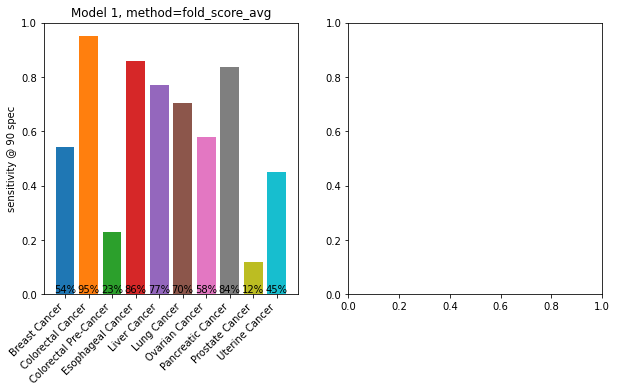

In [91]:
path = "Multi_cancer/Two_step_models/model_compare/refactor/outlier_chmfc_vp2_crc_subset_refactor" 

onestep_score_dict = scores_by_model(bucket, path, steps=1)

In [ ]:
len(onestep_score_dict.keys())

In [ ]:
# plot baseline vs refactored one-step
def _log(x):
    return np.log(x + 1)
x = []
y = []
for sid in baseline_score_dict.keys():
    x.append((baseline_score_dict[sid]))
    #y.append(two_step_dict[sid])
    y.append((onestep_score_dict[sid]))
plt.figure()
plt.scatter(x,y)
#plt.ylabel("two step model score")
plt.xlabel("baseline model score")
plt.ylabel("refactored model score")

In [ ]:
# old binary model with fidelis samples added, using TOO_ratio rule
path = "Multi_cancer/Two_step_models/model_compare/refactor/outlier_chmfc_binary_log_reg_all_reg_vp2_++" 

BLR_score_dict = scores_by_model(bucket, path, steps=2)

In [ ]:
# refactored binary model (with fidelis), using TOO_ratio
path = "Multi_cancer/Two_step_models/model_compare/refactor/outlier_chmfc_binary_log_reg_refactor_vp2_++" 

BLR_refactor_score_dict = scores_by_model(bucket, path, steps=2)

In [ ]:
# plot BLR vs refactored BLR
def _log(x):
    return np.log(x + 1)
x = []
y = []
for sid in BLR_score_dict.keys():
    x.append((BLR_score_dict[sid][1]))
    #y.append(two_step_dict[sid])
    y.append((BLR_refactor_score_dict[sid][1]))
plt.figure()
plt.scatter(x,y)
#plt.ylabel("two step model score")
plt.xlabel("old BLR model score")
plt.ylabel("refactored BLR model score")

In [ ]:
# refactored multinomial
path = "Multi_cancer/Two_step_models/model_compare/refactor/outlier_chmfc_multinomial_histogram_refactor_vp2_++" 

MLR_refactor_score_dict = scores_by_model(bucket, path, steps=2)

In [ ]:
# old multinomial
path = "Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_multinomial_nhc_noscaler_histogram_tunable0pt0_vp2_++" 

MLR_score_dict = scores_by_model(bucket, path, steps=2)

In [ ]:
x = []
y = []
for sid in MLR_score_dict.keys():
    x.append((MLR_score_dict[sid][1]))
    #y.append(two_step_dict[sid])
    y.append((MLR_refactor_score_dict[sid][1]))
plt.figure()
plt.scatter(x,y)
#plt.ylabel("two step model score")
plt.xlabel("old MLR model score")
plt.ylabel("refactored MLR model score")

# tunable within folds

CRC Sens: 0.9637681159420289
Other Cancer Sens: 0.7352808988764045
Avg fold spec: 0.5584988962472406


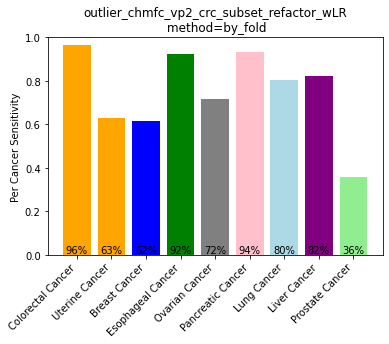

In [74]:
# model that adds log reg after outlier to test performance

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/refactor/outlier_chmfc_vp2_crc_subset_refactor_wLR"

df_samples = generate_exp_table(bucket, path, chains=1, spec=90)
df_samples_avg, call_rate_dict_0pt0 = plot_multicancer_sensitivities(df_samples, method='by_fold', spec=90)

In [24]:
df_samples.head()

,sample_id,fold,y_true,y_score,status,stage_x,subtype,inference,fold_call,stage_y,chain_score_0,chain_score_1,score_mean
0,4991,metadata_balanced_kfold_cancer_type_0,1,0.743142,Breast Cancer,2,None,False,1,IIB,0.256858,0.743142,0.896432
1,5006,metadata_balanced_kfold_cancer_type_0,1,0.990756,Breast Cancer,2,None,False,1,IIB,0.009244,0.990756,0.994472
2,14754,metadata_balanced_kfold_cancer_type_0,0,0.557029,Colorectal Normal / Healthy,None,None,False,1,None,0.442971,0.557029,0.591829
3,14879,metadata_balanced_kfold_cancer_type_0,0,0.660127,Colorectal Normal / Healthy,None,None,False,1,None,0.339873,0.660127,0.487553
4,20041,metadata_balanced_kfold_cancer_type_0,1,1.000000,Pancreatic Cancer,2,None,False,1,IIA,0.000000,1.000000,1.000000


CRC Sens: 0.9347826086956522
Other Cancer Sens: 0.5739325842696629
Avg fold spec: 0.7456953642384108


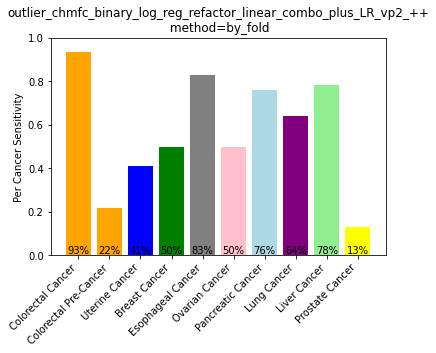

In [38]:
# linear combo model
# param = 1, equivalent to 1-step model only
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_binary_log_reg_refactor_linear_combo_plus_LR_vp2_++"

df_samples = generate_exp_table(bucket, path, spec=90)
df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='by_fold', spec=90)

CRC Sens: 0.5
Other Cancer Sens: 0.011235955056179775
Final Spec: 0.9024390243902439
CRC Sens: 0.8043478260869565
Other Cancer Sens: 0.015730337078651686
Final Spec: 0.9024390243902439
CRC Sens: 0.8623188405797102
Other Cancer Sens: 0.024719101123595506
Final Spec: 0.9024390243902439
CRC Sens: 0.9347826086956522
Other Cancer Sens: 0.4247191011235955
Final Spec: 0.9024390243902439
CRC Sens: 0.9492753623188406
Other Cancer Sens: 0.5707865168539326
Final Spec: 0.9024390243902439
CRC Sens: 0.9492753623188406
Other Cancer Sens: 0.6112359550561798
Final Spec: 0.9024390243902439


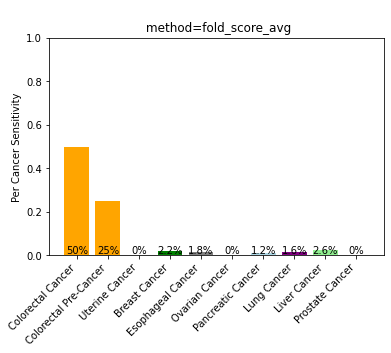

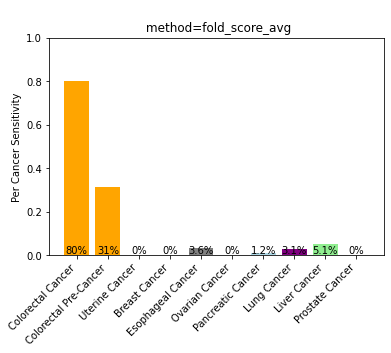

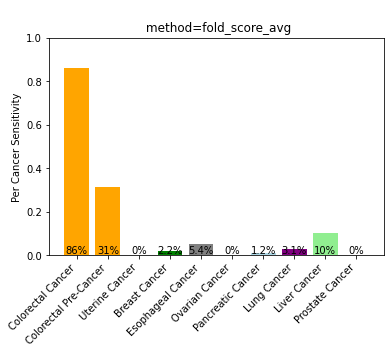

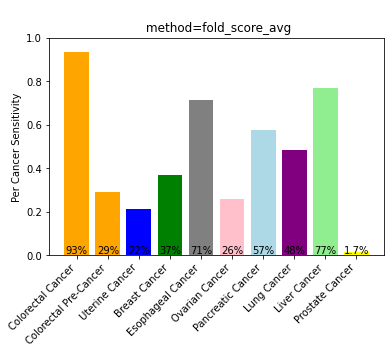

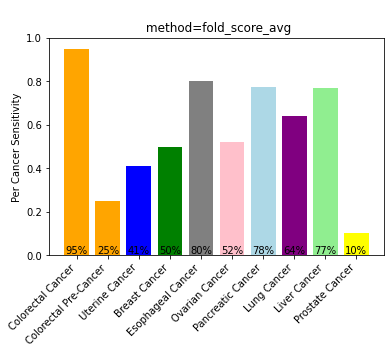

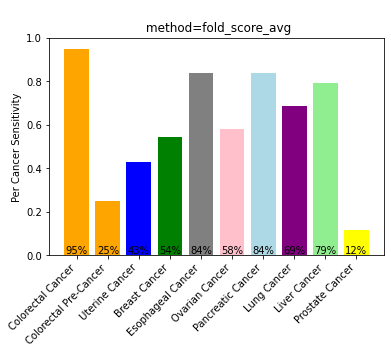

In [81]:
QUANTILES = [0.0, 0.2, 0.5, 0.7, 0.9, 1.0]
call_rates_dicts = []

for param in ["0pt0","0pt2","0pt5","0pt7","0pt9","1pt0"]:
    path = f"Multi_cancer/Two_step_models/model_compare/tunable/linear_combo_sweep/outlier_chmfc_binary_log_reg_refactor_linear_combo_plus_LR_vp2_++_{param}/"
    df_samples = generate_exp_table(bucket, path, spec=90)
    df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90)
    call_rates_dicts.append(call_rate_dict)

[[0.9024390243902439], [0.9024390243902439], [0.9024390243902439], [0.9024390243902439], [0.9024390243902439], [0.9024390243902439]]


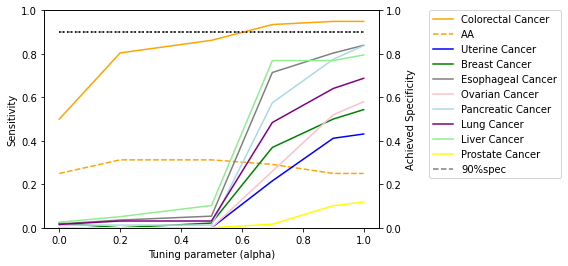

In [83]:
# tunable binomial
sens_by_quantile_plot(call_rates_dicts, quantiles=QUANTILES)

CRC Sens: 0.9492753623188406
Other Cancer Sens: 0.6112359550561798
Final Spec: 0.9024390243902439


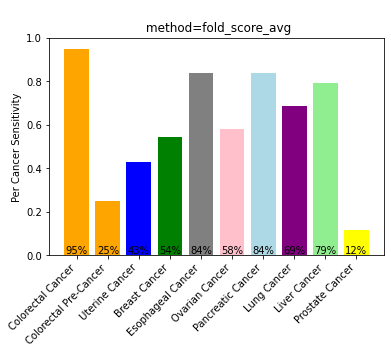

In [86]:
path = f"Multi_cancer/Two_step_models/model_compare/tunable/linear_combo_sweep/outlier_chmfc_multinomial_histogram_refactor_linear_combo_1pt0_vp2_++/"
df_samples = generate_exp_table(bucket, path, spec=90)
df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90)

CRC Sens: 0.11594202898550725
Other Cancer Sens: 0.0
Final Spec: 0.9024390243902439
CRC Sens: 0.6811594202898551
Other Cancer Sens: 0.033707865168539325
Final Spec: 0.9024390243902439
CRC Sens: 0.855072463768116
Other Cancer Sens: 0.06741573033707865
Final Spec: 0.9024390243902439
CRC Sens: 0.9492753623188406
Other Cancer Sens: 0.47415730337078654
Final Spec: 0.9024390243902439
CRC Sens: 0.9492753623188406
Other Cancer Sens: 0.5730337078651685
Final Spec: 0.9024390243902439
CRC Sens: 0.9492753623188406
Other Cancer Sens: 0.6112359550561798
Final Spec: 0.9024390243902439


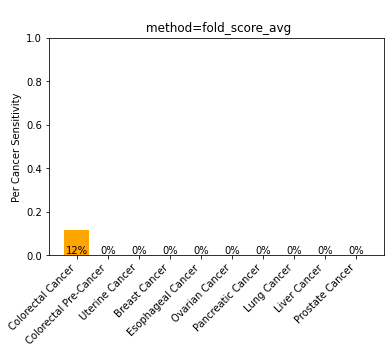

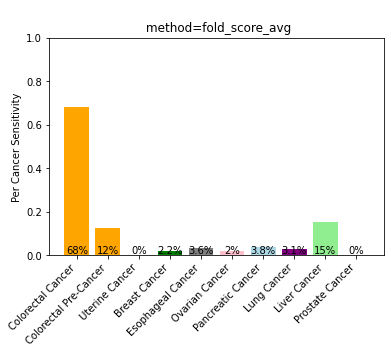

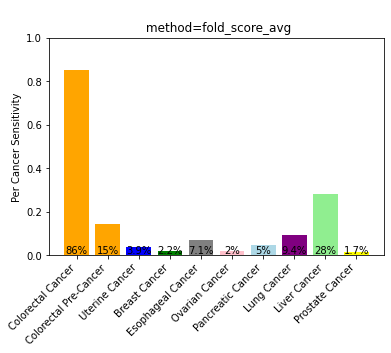

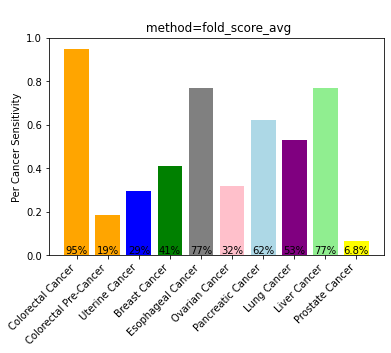

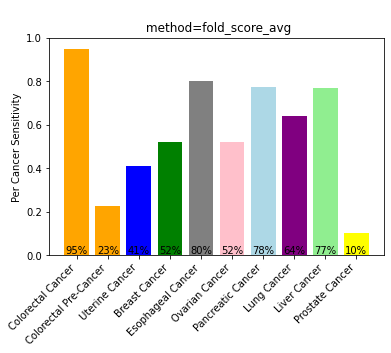

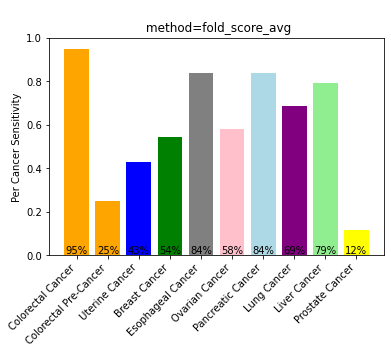

In [87]:
QUANTILES = [0.0, 0.2, 0.5, 0.7, 0.9, 1.0]
call_rates_dicts = []

for param in ["0pt0","0pt2","0pt5","0pt7","0pt9","1pt0"]:
    path = f"Multi_cancer/Two_step_models/model_compare/tunable/linear_combo_sweep/outlier_chmfc_multinomial_histogram_refactor_linear_combo_{param}_vp2_++/"
    df_samples = generate_exp_table(bucket, path, spec=90)
    df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90)
    call_rates_dicts.append(call_rate_dict)

[[0.9024390243902439], [0.9024390243902439], [0.9024390243902439], [0.9024390243902439], [0.9024390243902439], [0.9024390243902439]]


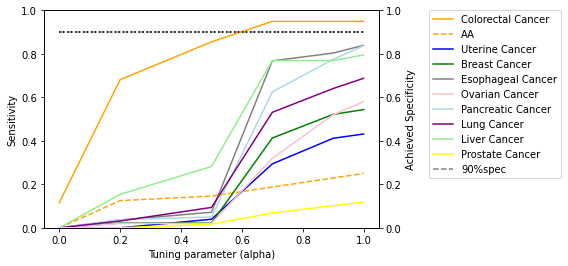

In [88]:
# multinomial tunable (using model2 prob(crc))
sens_by_quantile_plot(call_rates_dicts, quantiles=QUANTILES)

CRC Sens: 0.8623188405797102
Other Cancer Sens: 0.07865168539325842
Final Spec: 0.9024390243902439


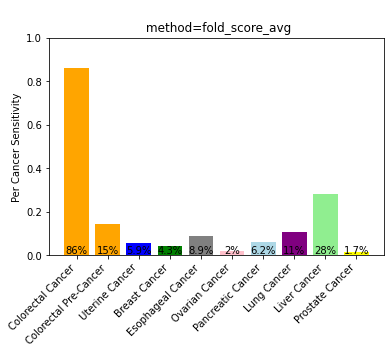

In [90]:
# multinomial tunable (using model2 1 - max(TOO)) param=0.5
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_multinomial_histogram_refactor_linear_combo_maxTOO_vp2_++/"

df_samples = generate_exp_table(bucket, path, spec=90)
df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90)

CRC Sens: 0.8623188405797102
Other Cancer Sens: 0.02696629213483146
Final Spec: 0.9024390243902439


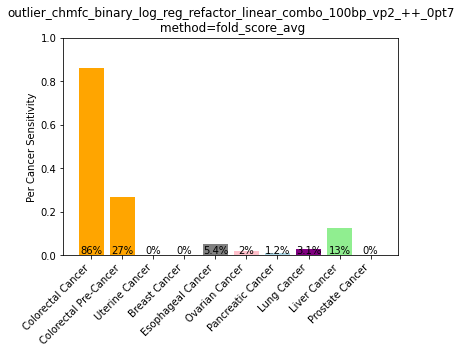

In [95]:
# binomial LR, tunable (=0.7), 100bp bins (Q4 handoff model)
path = f"Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_binary_log_reg_refactor_linear_combo_100bp_vp2_++_0pt7"
df_samples = generate_exp_table(bucket, path, spec=90, feature="mint_hmf_vp2_100bp_2021_09_26/v3")
df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90)

In [ ]:
# multinomial LR, tunable (=0.7), 100bp bins (Q4 handoff model)
path = f"Multi_cancer/Two_step_models/model_compare/tunable/outlier_chmfc_multinomial_histogram_refactor_linear_combo_0pt7_100bp_vp2_++"
df_samples = generate_exp_table(bucket, path, spec=90, feature="mint_hmf_vp2_100bp_2021_09_26/v3")
df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90)

CRC Sens: 0.9722222222222222
Other Cancer Sens: 0.5955056179775281
Final Spec: 0.9010238907849829


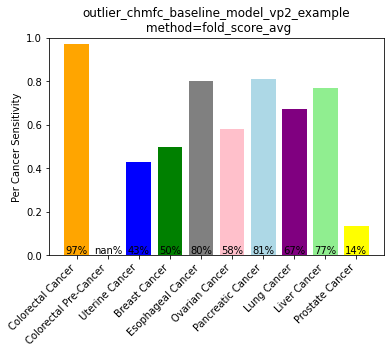

In [6]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/examples/outlier_chmfc_baseline_model_vp2_example" 
df_samples = generate_exp_table(bucket, path, spec=90)
df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90)

# Flyte sweep (not working)

In [ ]:
from dataclasses import replace
from typing import List

from pineappleflow.core.config.experiment_config import ExperimentConfig
from pineappleflow.core.sweeper.base import BaseSweeper

In [59]:
# construct a sweeper for running multiple experiments with different tuning params (on flyte)

class PfTrainSweeper(BaseSweeper):
    def generate_sweep_specs(self) -> List[ExperimentConfig]:
        configs = []
        for param in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]:
            name = f"{self._base_config.name}-param={str(param)}"
            spec_pipeline_yaml = self._base_config.pipeline_yaml
            spec_pipeline_yaml["model_spec"]["combination_rule_kwargs"]["tuning_param"] = param
            new_config = self.build_pineapple_spec(name=name, 
                                                   model_recipe_spec=spec_pipeline_yaml["model_spec"])
            with open(f"./experiment_yamls/tunable/linear_combo_sweep/spec_{str(param)}.yml", "w") as fout:
                fout.write(new_config)
            configs.append(new_config)
        return configs

sweeper = PfTrainSweeper(
    bucket="freenome-user-data-bgould",
    path="Multi_cancer/Two_step_models/model_compare/tunable/linear_sweep",
    rerun_existing_experiments=False,
    skip_analysis_hooks=True,
    hook_default="pineapple",
    base_config_path="./experiment_yamls/tunable/outlier_chmfc_binary_log_reg_refactor_linear_combo_plus_LR_vp2_++.yml"
)

In [ ]:
res = sweeper.run_sweep()

In [45]:
from pineappleflow.core.flyte.loaders.flyte_experiment_loader import FlyteExperimentLoader

In [57]:
# runids = ['f8bc8a2437f3b40f8afe',
#   'fc05fe708b9d24b87993',
#   'f1fddd11b92e7408580f',
#   'f905b37b6680d4d03955',
#   'f919e07da0824489cbee',
#   'f0b50fa6a12534a5c900',
#   'f514e4a087a234d27b86',
#   'f1a9894735dbe48648ac',
#   'f6cfee1660f8143a3973',
#   'f72a0be9c50d74179a4e',
#   'f266acf0630ae4094844',
#   ]

runids = [d["execution_id"] for d in res]
runids

['fc2127dde993a4d6c8c7',
 'f437d6e98c3e74beebaa',
 'f467cd4e32c74414e8fd',
 'f949af04bf50047bcbc0',
 'f77455e52750c43e0973',
 'fb54bbddb0fd840a9942',
 'fb7f95db066314d118c2',
 'feb0b232ff927488abd0',
 'fffa3c636280f42ed835',
 'f3655e1736c114fcb880',
 'ff94122949af4433e82a']

In [ ]:
# flyte not workng
# call_rates_dicts = []

# for runid, param in zip(runids, QUANTILES):
#     #path = f"freenome-user-data-bgould/Multi_cancer/Two_step_models/model_compare/tunable/linear_sweep/outlier_chmfc_binary_log_reg_refactor_linear_combo_1pt0_vp2_++-param=0.1/2021-12-16-pineapple-development-fulyqq2a
#     df_samples = generate_exp_table(bucket, chains=2, spec=90, flyte=True, runid=runid)
#     df_samples_avg, call_rate_dict = plot_multicancer_sensitivities(df_samples, method='by_fold', spec=90)
#     call_rates_dicts.append(call_rate_dict)

In [40]:
sens_by_quantile_plot(call_rates_dicts)

NameError: name 'sens_by_quantile_plot' is not defined